<div style='font-size: 3em'>SentiLens - Uncover reviews' hidden emotion</div>

__Prepared by:__ Tina Vu</br>
__Date:__ 20231208</br>

Employing aspect-based sentiment analysis (ABSA) to extract valuable feature insights from e-commerce product reviews, thereby empowering consumers to make more informed purchasing decisions and enhancing their overall user experience on the platform.

Utilizing manually annotated reviews for aspect sentiment analysis to extract aspects and predict sentiments from reviews. This enables consumers to obtain a condensed overview of sentiments related to various product features, eliminating the need to delve into an extensive array of reviews. As a result, the decision-making process becomes more streamlined and user-friendly.

__Phase:__
1. Supervised ABSA (What, How): Aspect term extration and aspect term sentiment classification
2. Unsupervised ABSA
3. Add 'Why' into ABSA

This notebook/ project may only aim to complete the first phase.

<div style='font-size: 2em'>Phase 1 - Aspect Extration</div>

**Table of contents**<a id='toc0_'></a>    
- 1. [Import & prepare dataset](#toc1_)    
  - 1.1. [Import data](#toc1_1_)    
  - 1.2. [Preparing dataset for modelling](#toc1_2_)    
    - 1.2.1. [BIO tagging encode](#toc1_2_1_)    
    - 1.2.2. [Word features](#toc1_2_2_)    
    - 1.2.3. [Define data processing functions](#toc1_2_3_)    
    - 1.2.4. [Complete data preparation](#toc1_2_4_)    
- 2. [Exploratory data analysis](#toc2_)    
  - 2.1. [Flatten word features](#toc2_1_)    
  - 2.2. [Aspect word distribution](#toc2_2_)    
  - 2.3. [Part-of-speech](#toc2_3_)    
  - 2.4. [Opinion Lexicon - Sentiment](#toc2_4_)    
- 3. [Split data](#toc3_)    
- 4. [Random forest](#toc4_)    
  - 4.1. [Data prepration](#toc4_1_)    
    - 4.1.1. [Flattening](#toc4_1_1_)    
    - 4.1.2. [Oversampling](#toc4_1_2_)    
    - 4.1.3. [Scaling](#toc4_1_3_)    
  - 4.2. [Model](#toc4_2_)    
  - 4.3. [Test](#toc4_3_)    
  - 4.4. [Feature importance](#toc4_4_)    
- 5. [CRF model](#toc5_)    
  - 5.1. [Model](#toc5_1_)    
  - 5.2. [Test](#toc5_2_)    
  - 5.3. [Further look into the model's mistakes](#toc5_3_)    
  - 5.4. [BIO construction violations](#toc5_4_)    
- 6. [Model evaluation](#toc6_)    
  - 6.1. [Metric for model evaluation](#toc6_1_)    
- 7. [Sample visualization](#toc7_)    
- 8. [Next steps](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [49]:
import numpy as np
import pandas as pd
import re
import string
import random

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from highlight_text import HighlightText, ax_text, fig_text

import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('opinion_lexicon')
# nltk.download()

# Load positive and negative words from the opinion lexicon
POSITIVE_WORDS = set(opinion_lexicon.positive())
NEGATIVE_WORDS = set(opinion_lexicon.negative())
# Load common stop words in english
EN_STOP_WORDS = set(stopwords.words('english'))
# Define context switching words
CONTEXT_SWITCHING_WORDS = ['but', 'yet', 'however', 'nevertheless', 'still', 'nonetheless', 'although', 'though', 'even though', 'while']



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

from imblearn.over_sampling import SMOTE

from sklearn_crfsuite import CRF
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder



[nltk_data] Downloading package punkt to /Users/tina.vu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/tina.vu/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [50]:
def vizualize_samples (sentences, tag_dict):

  fig, ax = plt.subplots(figsize=(30,10))
  font = {'family' : 'arial',
          'size'   : 16}
  matplotlib.rc('font', **font)
  final_text = []
  color = []
  pos_element = {"bbox": {"edgecolor": "Green", "facecolor": "#99FF00", "linewidth": 1.5, "pad": 1}} 
  neu_element = {"bbox": {"edgecolor": "Orange", "facecolor": "Yellow", "linewidth": 1.5, "pad": 1.5}} 
  neg_element = {"bbox": {"edgecolor": "Red", "facecolor": "#FF99CC", "linewidth": 1.5, "pad": 1}}
  con_element = {"bbox": {"edgecolor": "#6600FF", "facecolor": "#99FFFF", "linewidth": 1.5, "pad": 1}}
  
  color_map = {'POS': pos_element, 'NEU': neu_element, 'NEG':neg_element, 'CON': con_element}

  final_text.append('\n---------------\n')
  final_text.append(f'  <positive>  ')
  color.append(pos_element)
  final_text.append(f'  <negative>  ')
  color.append(neg_element)
  final_text.append(f'  <neutral>  ')
  color.append(neu_element)
  final_text.append(f'  <conflict>  ')
  color.append(con_element)
  final_text.append('\n---------------\n\n\n')

  for s in range(0, len(sentences)):
    
    chunk = []
    next_tag = ''
    
    for k in tag_dict:
      # print(k)
      tags = tag_dict[k]
      final_text.append(f'\n({k}) ')
      for w in range(0, len(sentences[s])):
        word = sentences[s][w]
        tag = tags[s][w]

        if w + 1 < len(sentences[s]):
          next_tag = tags[s][w+1]
        else:
          next_tag = 'O'


        if tag == 'O':
          final_text.append(word)
        elif (tag[:1] in ['B','I']):
          chunk.append(word)

        if (next_tag[:1] in ['B','O']) & (len(chunk) > 0):
          final_text.append(f'< {" ".join(chunk)}> ')
          color.append(color_map[tag[2:]])
          chunk = []
    
    final_text.append('\n---------------\n')


    HighlightText(x=0, y=1,
                s=' '.join(final_text),
                highlight_textprops=color,
                ax=ax)
                
    plt.axis('off')

# 1. <a id='toc1_'></a>[Import & prepare dataset](#toc0_)

## 1.1. <a id='toc1_1_'></a>[Import data](#toc0_)

We will load laptop reviews dataset with aspect term & sentiment annotations.

The dataset comes in two parts:
- train: 3,048 records
- test: 800 records

Each record is a sentence with zero, one or multiple aspect terms. Each aspect term has the following features:
- start character index
- end character index
- sentiment/ polarity (positive or negative)

In [51]:
df_train = pd.read_json('data/laptop/train.json')
print('df_train shape: ', df_train.shape)

df_val = pd.read_json('data/laptop/validate.json') # This will only be used for the very last step to evaluate how well the model is, but is input now for validating the BIO tagging to ensure the function works properly
df_val.set_index('id', inplace=True)
print('df_val shape: ', df_val.shape)

df_train shape:  (3048, 3)
df_val shape:  (800, 2)


In [52]:
df_train.head()

,id,text,aspects
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral', 'from..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."
4,2193,The other day I had a presentation to do for a...,"[{'term': '', 'polarity': '', 'from': 0, 'to':..."


## 1.2. <a id='toc1_2_'></a>[Preparing dataset for modelling](#toc0_)

The task we are solving is Named Entity Recognition (NER) which is a sequential labeling task, a.k.a we would like to predict whether a token (word) in each sentence is part of an aspect term or not.

In order to prepare the data for NER task, we need to label our tokens. Here, I implemented a unified BIO tagging technique which combines aspect boundaries and aspect sentiment.

Word boundaries:
- B: indicates the 1st word in the aspect term
- I: indicates the subsequent word in the aspect term
- O: indicates words that are not part of any aspect term

Aspect sentiment:
- POS: positive
- NEU: neutral
- NEG: conflict

This BIO label technique is more effective in recognizing unigram and n-gram aspect terms comparing to a binary classification (whether a token is part of an aspect). By using a unified a approach, we can combine two tasks: aspect extraction and sentiment classification into one task.

In [53]:
# First, I will need to drop some duplicated data in our training dataset, as identified in the EDA process.
df_train.drop_duplicates(subset='text', inplace=True)

# We have removed 12 duplicated records in our training dataset
df_train.shape

(3036, 3)

### 1.2.1. <a id='toc1_2_1_'></a>[BIO tagging encode](#toc0_)

Here, I defined a function to encode our sentences' aspects using a unified BIO tagging technique (<a href='https://arxiv.org/pdf/1811.05082.pdf'>reference</a>) that combines aspect boundaries and aspect sentiment in a single label.

Word boundaries:
- B: indicates the 1st word in the aspect term
- I: indicates the subsequent word in the aspect term
- O: indicates words that are not part of any aspect term

Aspect sentiment:
- POS: positive
- NEU: neutral
- NEG: conflict

Unified BIO tagging will be like: B-NEU, I-NEU

For example:
['I', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the', 'good', 'battery', 'life', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NEU', 'I-NEU', 'O', 'O', 'O', 'O', 'O', 'B-POS', 'I-POS', 'I-POS']

Since the dataset provides a full sentence and annotates aspect term using character index, we cannot perform word_tokenize directly on the raw text due to:
  1. Word_tokenize separates punctuation as a single normal token which makes it difficult to re-string (combine) word tokens (using ' '.join(tokens)) for character index, as it adds extra spaces between word and punctuations, thus invalidate character index for aspect terms. This makes it very difficult to align the aspect term character index and word index accurately.</br>
  E.g. "I love pizza, cheese.", term indexes are (7,12),(16,22), re-string tokens from word_tokenize (' '.join(tokens)) can turn the sentence into "I love pizza__\<extra space\>__, cheese__\<extra space\>__.". The char index of the aspect terms now become (7,12), `(17,23)`.
  
  2. Word_tokenize tends to not separate words that have special characters between them (other than space and common punctuations like <,.:;>), while some terms treated those chunks as separated terms. 
  E.g. "size/screen" is a single token based on word_tokenize, while terms defined this as two separate tokens. 

Therefore, I applied the below approach to acoomodate the above short commings:
  1. Add aspect_prefix & aspect_suffix (with additional spaces in order to overcome issue #2) to the start & end of each aspect term (to overcome issue #1) in the sentence using from, to char index as supplied by the dataset
  2. Perform word_tokenize on the new aspect_annotated_sentence
  3. Perform BIO tagging on the sentence token
  
  \* I have also looked into removing punctuation tokens out of the training data, however, after reviewing some of the samples, punctuation is actually important for the model to learn and break down aspect terms into different chunks. For example: "window, screen", without punctuation token, the model tend to predict them as a single aspect term: "window screen", however, they should be 2 separated terms: "window" & "screen". Therefore, I believe it is very important to retain punctuation in the training data set. As the same time, I have also added `is_punctuation` feature to our training data.

In [54]:
def encode_unified_BIO (x, sentiment_tag=False):
  '''  This function puts aspect's details into a dictionary, and multiple aspect as an array
  
  Parameter:
  - ASPECTS: dictionary array
    dictionary of
    - term
    - polarity
    - term_start
    - term_end

    For example:
    [
      {'term':'cord', 'polarity':'neutral', 'from': 41, 'to': 45},
      {'term':'battery life', 'polarity':'positive', 'from': 74, 'to': 86}
    ]
  - SENTIMENT_TAG: boolean
    True: if we want to return sentiment polarity with BIO tagging (unified BIO)
    False: if we do not want to return sentiment polarity with BIO tagging (just pure BIO)
    
  Output: 
  - TEXT_TOKENS: array of string
    Sentence tokens
    E.g. ['Boot', 'time', 'is', 'super', 'fast', ',', 'around', 'anywhere', 'from', '35', 'seconds', 'to', '1', 'minute', '.']
    
  - TAGS: array of string
    Unified BIO tags (if sentiment_tag paratement is set to True) or BIO tags (if sentiment_tag is set to False)
      Aspect boundaries:
        B: beginning of aspect term
        I: subsequent words of aspect term
        O: outside of aspect term
      Sentiment:
        POS: positive
        NEG: negative
        NEU: neutral
        CON: conflict
    E.g. ['B-POS', 'I-POS', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

  - ASPECT_COMPUTE_PAIRS: tuple of two strings
    1st String combining of all aspect terms as provided by the dataset
    2nd String combining of all aspect terms from annotated BIO tagged using text_token
    E.g.(' Boot time', ' Boot time')

  - IS_INCORRECT_TAGGING: boolean
    True: when ASPECT_COMPUTE_PAIRS is different from each other
    False: when ASPECT_COMPUTE_PAIRS is exactly like each other
    This may return False, when there is some special characters in aspect term that causing them to be splitted into a different token.
    E.g. aspect_term `15" TV`, computed_term can return `15 " TV`. Thus, they are not exactly matching each other, but they should be okay
  '''

  aspects = x['aspects']
  aspects = sorted(aspects, key=lambda d: int(d['from']))  # sort aspects based on from, some aspects are not sorted: later terms in the sentence sometimes are placed before terms appear earlier. 
  
  text = x['text']

  sentiment_tag_map = {'neutral': '-NEU'
                       ,'conflict':'-CON'
                       ,'positive':'-POS'
                       ,'negative':'-NEG'}
  
  aspect_prefix = ' XXATBXX' # add leading space to break words if they are in the same chunk. E.g. "size/window" --> "size / window"
  aspect_suffix = 'XXATEXX ' # add trailing space

  # these are for validation to ensure the BIO tagging is accurate
  aspect_terms = ''
  aspect_terms_compute = ''

  # we cannot perform word_tokenize directly on the raw text due to:
  # 1. there is no space between punctuation and word, which makes it difficult to calculate word index from char index when concatenating word tokens for word index search
  # 2. terms can be partial of a word token, e.g. "size/screen" is a single token based on word_token, while terms defined this as two separate terms. 
  # Therefore, I applied the below approach:
  # 1. Add aspect_prefix & aspect_suffix to the start & end of each aspect term in the sentence using from, to char index as supplied by the dataset
  # 2. Perform word_tokenize on the new aspect_annotated_sentence
  # 3. Perform BIO tagging on the sentence token

  # 1. Add aspect prefix & suffix to the sentence
  aspect_annotated_sentence = text

  for i, k in enumerate(aspects):
    term = k['term']
    
    if k['term'] != '': # there are empty aspects but still have an empty dict structure, so we only perform tagging for those that has `term` != ''
      # this is for validation purposes only
      aspect_terms += ' ' + term 

      if k['polarity'] == '':
        print(k['id'])

      polarity = sentiment_tag_map[k['polarity']] if sentiment_tag == True else '' # get polarity encode
  
      i_from = int(k['from']) + i * (len(aspect_prefix) + len(aspect_suffix) + len(polarity)) # re-calculate from & by shifting them by the length of additional character added for aspect prefix & suffix
      i_to = int(k['to']) + i * (len(aspect_prefix) + len(aspect_suffix) + len(polarity))
      
      aspect_annotated_sentence = aspect_annotated_sentence[:i_from] + aspect_prefix+ polarity + aspect_annotated_sentence[i_from:i_to] + aspect_suffix + aspect_annotated_sentence[i_to:]
  
  # Tokenize aspect annotated sentence
  text_tokens = word_tokenize(aspect_annotated_sentence)

  # Perfom BIO tagging
  aspect_start = False
  polarity = ''
  token_BIO_pairs = []

  for i,k in enumerate(text_tokens):
    tag = 'O' # default token tag as 'O' outside of aspect term

    if k[:7] == aspect_prefix.strip(): # if we see aspect prefix in a term, update tag as 'B' & set aspect_start as True
      aspect_start = True
      polarity = k[7:11] # extract polarity for next following tokens if there is
      tag = 'B' + polarity
      
    elif aspect_start == True: # if token does not have aspect_prefx, set tag to I if aspect_start is still True
      tag = 'I' + polarity
      
    else: # if aspect_start is False or if there is no aspect prefix
      tag = 'O'

    text_tokens[i] = re.sub(aspect_prefix.strip() + '.{4}', '',text_tokens[i]).replace(aspect_suffix.strip(),'') # clean text token by removing aspect prefix, polarity & aspect suffix if any

    token_BIO_pairs.append((text_tokens[i], tag))
    
    if k[-7:] == aspect_suffix.strip(): # If token contains aspect_suffix, restart aspect_start as False and polarity as empty
      aspect_start = False
      polarity = ''
    
  # This is for validation purposes only
  for i, k in enumerate(token_BIO_pairs):
    if k[1] != 'O':
      aspect_terms_compute += ' ' + k[0]
  
  # This is for validation purposes only
  aspect_compute_pairs = (aspect_terms, aspect_terms_compute)
  is_incorrect_tagging = True if aspect_terms != aspect_terms_compute  else False

  return pd.Series([token_BIO_pairs, aspect_compute_pairs, is_incorrect_tagging])

In [55]:
df_train[['token_BIO_pairs', 'aspect_compute_pairs','is_incorrect_tagging']] = df_train.apply(lambda x: encode_unified_BIO(x, True), axis=1)
df_val[['token_BIO_pairs', 'aspect_compute_pairs','is_incorrect_tagging']] = df_val.apply(lambda x: encode_unified_BIO(x, True), axis=1)

After performing BIO encode, we want to check if there is any misclassification using is_incorrect_tagging.

There are only 20 possible inccorect BIO labels in df_train and 10 for df_val.

Looking through a few examples, it seems like the issues are mainly around special characters inside aspect terms that cause the comparision strings to be different, however, the BIO labels are still accurate. 

In [56]:
print('# of possible incorrect labels in df_train: ', df_train['is_incorrect_tagging'].sum())
print('# of possible incorrect labels in df_train: ', df_val['is_incorrect_tagging'].sum())
print('\n\n Some examples')

n_samples = 2
sample = df_train[df_train['is_incorrect_tagging']].copy().reset_index()

for i in range(0, n_samples):
  s = sample.iloc[i]
  print(s['text'])
  print(s['aspects'])
  print(s['aspect_compute_pairs'])
  print(s['token_BIO_pairs'])
  print('\n')

# of possible incorrect labels in df_train:  20
# of possible incorrect labels in df_train:  10


 Some examples
The tech guy then said the service center does not do 1-to-1 exchange and I have to direct my concern to the "sales" team, which is the retail shop which I bought my netbook from.
[{'term': 'service center', 'polarity': 'negative', 'from': '27', 'to': '41'}, {'term': '"sales" team', 'polarity': 'negative', 'from': '109', 'to': '121'}, {'term': 'tech guy', 'polarity': 'neutral', 'from': '4', 'to': '12'}]
(' tech guy service center "sales" team', " tech guy service center  '' sales '' team")
[('The', 'O'), ('tech', 'B-NEU'), ('guy', 'I-NEU'), ('then', 'O'), ('said', 'O'), ('the', 'O'), ('service', 'B-NEG'), ('center', 'I-NEG'), ('does', 'O'), ('not', 'O'), ('do', 'O'), ('1-to-1', 'O'), ('exchange', 'O'), ('and', 'O'), ('I', 'O'), ('have', 'O'), ('to', 'O'), ('direct', 'O'), ('my', 'O'), ('concern', 'O'), ('to', 'O'), ('the', 'O'), ('', 'B-NEG'), ("''", 'I-NEG'), ('sales', 'I-N

### 1.2.2. <a id='toc1_2_2_'></a>[Word features](#toc0_)
Here we will populate some word features for each token (word) in the sentence, such as:
- word
- stemming / lemming versions of word
- part of speech (POS) of word
- words sentiment lexicon
- context words within a pre-defined window (5 words surrounding the token)
- context words stemming/ lemming
- context words POS
- context words sentiment lexicon
- ...

The list is not exhaustive, and is an iterative process as we perform EDA and go back and refining/ adding more features.

In [57]:
# Function to convert sentences into features
def word2features(sent, i, backward_window_size=5, forward_window_size=5): 
    word = sent[i][0]

    _, pos = zip(*nltk.pos_tag([x[0] for x in sent]))

    tag_sentiment = lambda word: 'POS' if word in POSITIVE_WORDS else 'NEG' if word in NEGATIVE_WORDS else 'NEU'
    features = {
        'word.lower()': word.lower(), # word
        'word.index()': i,
        'word.reverseindex()': len(sent) - 1 - i, # reverse index - nth word from end of sentence
        'word.pos': pos[i],
        'word.opinionlexicon': tag_sentiment(word.lower()),
        'word.contextswitching': word.lower() in CONTEXT_SWITCHING_WORDS,
        'word.isstopword()': word.lower() in EN_STOP_WORDS,
        'word[-3:]': word[-3:], # last 4 char
        'word[-2:]': word[-2:], # last 3 char - in case of -ing, -ion, etc.
        'word.isupper()': word.isupper(), # is the word in upper case
        'word.istitle()': word.istitle(), # is the first letter of the word in upper case
        'word.isdigit()': word.isdigit(), # is the word full of digit
        'word.ispunctuation()': word.lower() in string.punctuation, # is punctuation
    }

    if i > 0:
        for k in range(1, min(backward_window_size, i)+1):
            prev_word = sent[i - k][0]
            prev_pos = pos[i - k]
            
            features.update({
                f'-{k}:word.lower()': prev_word.lower(),
                f'-{k}:word.pos': prev_pos,
                f'-{k}:word.opinionlexicon': tag_sentiment(word.lower()),
                f'-{k}:word.contextswitching': prev_word.lower() in CONTEXT_SWITCHING_WORDS,
                f'-{k}:word.isstopword()': prev_word in EN_STOP_WORDS,
                f'-{k}:word.istitle()': prev_word.istitle(),
                f'-{k}:word.isupper()': prev_word.isupper(),
                f'-{k}:word.ispunctuation()': prev_word.lower() in string.punctuation, # is punctuation
            })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        for k in range(1, min(forward_window_size, len(sent) - i - 1)+1):
            next_word = sent[i + k][0]
            next_pos = pos[i + k]

            features.update({
                f'+{k}:word.lower()': next_word.lower(),
                f'+{k}:word.pos': next_pos,
                f'+{k}:word.opinionlexicon': tag_sentiment(word.lower()),
                f'+{k}:word.contextswitching': next_word.lower() in CONTEXT_SWITCHING_WORDS,
                f'+{k}:word.isstopword()': next_word in EN_STOP_WORDS,
                f'+{k}:word.istitle()': next_word.istitle(),
                f'+{k}:word.isupper()': next_word.isupper(),
                f'+{k}:word.ispunctuation()': next_word.lower() in string.punctuation, # is punctuation
            })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Function to convert sentences into feature sequences
def sent2features(sent, backward_window_size=5, forward_window_size=5):
    return [word2features(sent, i, backward_window_size, forward_window_size) for i in range(len(sent))]

### 1.2.3. <a id='toc1_2_3_'></a>[Define data processing functions](#toc0_)
These functions help us streamline and ensure consistencies in our data preparation

In [58]:
def prepare_df(df_input, backward_window_size=5, forward_window_size=5, show_BIO_errors=False):
  df = df_input.copy()
  df[['token_BIO_pairs','aspect_compute_pairs', 'is_incorrect_tagging']] = df.apply(lambda x: encode_unified_BIO(x, True), axis=1)

  X = [sent2features(sentence, backward_window_size, forward_window_size) for sentence in df['token_BIO_pairs']]
  y = [[word[1] for word in sentence] for sentence in df['token_BIO_pairs']] 

  # These are for showing examples if there are any issues during BIO tagging
  errors = df['is_incorrect_tagging'].sum()
  print('# of possible incorrect labels in df: ', errors, f'({errors/len(df)*100:.0f}% total records)')
  print('\n\n Some incorrect examples')

  if (errors > 0) & (show_BIO_errors == True):
    n_samples = 3
    sample = df[df['is_incorrect_tagging']].copy().reset_index()

    for i in range(0, n_samples):
      s = sample.iloc[i]
      print('Text: ', s['token_BIO_pairs'])
      print('Dataset provided aspects - original form: ', s['aspects'])
      print('Dataset provided aspects - Computed aspects: ', s['aspect_compute_pairs'])
      print('Unified BIO tagging: ', s['token_BIO_pairs'])
      # print('Unified BIO tagging clean: ', s['token_BIO_pairs_clean'])
      print('Total text tokens: ', len(s['token_BIO_pairs']))
      print('\n')

  return pd.Series([X, y])

In [59]:
def sentences_to_features(string_sentences, backward_window_size=5, forward_window_size=5):
  sentences_token = [word_tokenize(sentence) for sentence in string_sentences]
  X =  [sent2features(sentence, backward_window_size, forward_window_size) for sentence in sentences_token]
  return X

### 1.2.4. <a id='toc1_2_4_'></a>[Complete data preparation](#toc0_)

df_train looks ok with the errors we have found previously.

In [60]:
# Reload the data to make sure we have the clean data
df_train = pd.read_json('data/laptop/train.json')

# Drop duplicates as we identified and inspected previously
df_train.drop_duplicates(subset='text',inplace=True)

# Prepare the data: BIO tagging & get word features
backward_window_size = 5 # look backward 5 words
forward_window_size = 5 # look forward 5 words
df_train[['features', 'unified_BIO_tag']] = prepare_df(df_train, backward_window_size, forward_window_size, True)

# of possible incorrect labels in df:  20 (1% total records)


 Some incorrect examples
Text:  [('The', 'O'), ('tech', 'B-NEU'), ('guy', 'I-NEU'), ('then', 'O'), ('said', 'O'), ('the', 'O'), ('service', 'B-NEG'), ('center', 'I-NEG'), ('does', 'O'), ('not', 'O'), ('do', 'O'), ('1-to-1', 'O'), ('exchange', 'O'), ('and', 'O'), ('I', 'O'), ('have', 'O'), ('to', 'O'), ('direct', 'O'), ('my', 'O'), ('concern', 'O'), ('to', 'O'), ('the', 'O'), ('', 'B-NEG'), ("''", 'I-NEG'), ('sales', 'I-NEG'), ("''", 'I-NEG'), ('team', 'I-NEG'), (',', 'O'), ('which', 'O'), ('is', 'O'), ('the', 'O'), ('retail', 'O'), ('shop', 'O'), ('which', 'O'), ('I', 'O'), ('bought', 'O'), ('my', 'O'), ('netbook', 'O'), ('from', 'O'), ('.', 'O')]
Dataset provided aspects - original form:  [{'term': 'service center', 'polarity': 'negative', 'from': '27', 'to': '41'}, {'term': '"sales" team', 'polarity': 'negative', 'from': '109', 'to': '121'}, {'term': 'tech guy', 'polarity': 'neutral', 'from': '4', 'to': '12'}]
Dataset pro

In [61]:
df_train.head()

,id,text,aspects,features,unified_BIO_tag
0,2339,I charge it at night and skip taking the cord ...,"[{'term': 'cord', 'polarity': 'neutral', 'from...","[{'word.lower()': 'i', 'word.index()': 0, 'wor...","[O, O, O, O, O, O, O, O, O, B-NEU, O, O, O, O,..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'word.lower()': 'i', 'word.index()': 0, 'wor...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,1316,The tech guy then said the service center does...,"[{'term': 'service center', 'polarity': 'negat...","[{'word.lower()': 'the', 'word.index()': 0, 'w...","[O, B-NEU, I-NEU, O, O, O, B-NEG, I-NEG, O, O,..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'word.lower()': 'i', 'word.index()': 0, 'wor...","[O, O, O, O, O, O, O, O, O]"
4,2193,The other day I had a presentation to do for a...,"[{'term': '', 'polarity': '', 'from': 0, 'to':...","[{'word.lower()': 'the', 'word.index()': 0, 'w...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


# 2. <a id='toc2_'></a>[Exploratory data analysis](#toc0_)

## 2.1. <a id='toc2_1_'></a>[Flatten word features](#toc0_)

We are going to flatten our word features into a pandas dataframe for easier exploration.

In [62]:
def features2df(sentence_index, X):
  '''
  This function takes in array of (array of dictionary) and flattens it to a pandas dataframe with all features as columns.
  Each element in an array is a sentence which is an array of dictionaries of each word and its features
  Missing features will have a null value.

  INPUT: 
  -----------------------
  SENTENCE INDEX: int
  This give the index of the sentence

  '''
  df = pd.DataFrame(X)
  df['nth_sentence'] = sentence_index
  return df

In [63]:
# Convert word features into data frame
df_features = pd.concat([features2df(df_train.iloc[i]['id'], df_train.iloc[i]['features']) for i in range(0, len(df_train))], ignore_index=True)
df_features['unified_BIO_tag'] = [tag for sentence in df_train['unified_BIO_tag'] for tag in sentence]

# Generalized aspect tag
df_features['is_aspect'] = df_features['unified_BIO_tag'].str[:1].apply(lambda x: 'aspect' if x in ['B','I'] else 'non-aspect')
df_features['sentiment'] = df_features['unified_BIO_tag'].str[-3:]

In [64]:
df_features.head()

,word.lower(),word.index(),word.reverseindex(),word.pos,word.opinionlexicon,word.contextswitching,word.isstopword(),word[-3:],word[-2:],word.isupper(),...,-5:word.contextswitching,-5:word.isstopword(),-5:word.istitle(),-5:word.isupper(),-5:word.ispunctuation(),EOS,nth_sentence,unified_BIO_tag,is_aspect,sentiment
0,i,0,18,PRP,NEU,False,True,I,I,True,...,NaN,NaN,NaN,NaN,NaN,NaN,2339,O,non-aspect,O
1,charge,1,17,VBP,NEU,False,False,rge,ge,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2339,O,non-aspect,O
2,it,2,16,PRP,NEU,False,True,it,it,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2339,O,non-aspect,O
3,at,3,15,IN,NEU,False,True,at,at,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2339,O,non-aspect,O
4,night,4,14,NN,NEU,False,False,ght,ht,False,...,NaN,NaN,NaN,NaN,NaN,NaN,2339,O,non-aspect,O


## 2.2. <a id='toc2_2_'></a>[Aspect word distribution](#toc0_)

It is a good idea to look into the dataset to understand what are the distributions of all the word tags. 

- "O" (non-aspect term) words are dominant in the dataset, while, conflict aspect terms are very few, which will be a challenge in training and evaluating the model.
- "B" tags are more common than "I" tags which indicates that the dataset has a lot of singular aspect terms comparing to multi-word aspect terms.

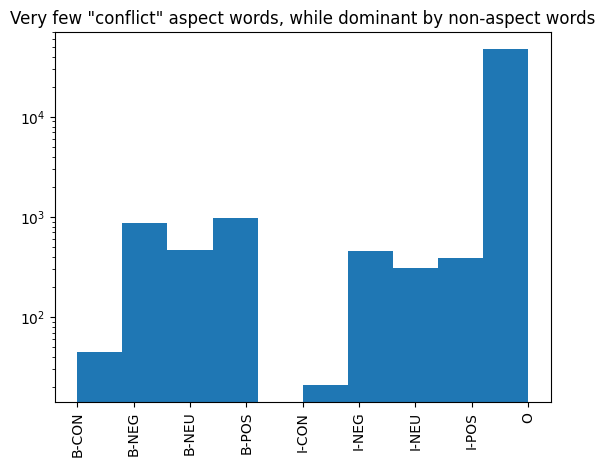

In [65]:
plt.hist(df_features['unified_BIO_tag'].sort_values())
plt.yscale("log")
plt.xticks(rotation=90)
plt.title('Very few "conflict" aspect words, while dominant by non-aspect words')
plt.show()

## 2.3. <a id='toc2_3_'></a>[Part-of-speech](#toc0_)

Aspect terms are often nouns and are verb objectives or subject. Let's inspect their part of speech to confirm this.

Same definition of POS tags:
- __CD__: Cardinal number (e.g., "one", "two", "3")
- __DT__: Determiner (e.g., "the", "a", "this")
- __IN__: Preposition or subordinating conjunction (e.g., "in", "on", "at")
- __IN__: Preposition or subordinating conjunction (e.g., "in", "on", "at")
- __JJ__: Adjective (e.g., "big", "happy", "green")
- __NN__: Noun, singular or mass (e.g., "dog", "city", "love")
- __NNP__: Proper noun, singular (e.g., "John", "Paris", "December")
- __NNS__: Noun, plural (e.g., "dogs", "cities", "loves")
- __PRP__: Personal pronoun (e.g., "I", "you", "he")
- __RB__: Adverb (e.g., "quickly", "very", "well")
- __VB__: Verb, base form (e.g., "eat", "run", "play")

\>80% aspect terms are nouns, while non-aspect words have very uniform distribution for all part-of-speech.

\* ***WARNING*** * 

*If you see this error running the below cell: `ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed`.*

*Try run this command: `pip install --upgrade nbformat` and restart your kernal/VS code.*

In [66]:
# Count words per each POS per each tag
pos_counts = df_features.groupby(['is_aspect', 'word.pos']).agg(word_count=pd.NamedAgg(column='is_aspect', aggfunc='count')).reset_index()

# Separate data to aspect & non-aspect words
aspect_pos_counts = pos_counts[pos_counts['is_aspect'] == 'aspect']
non_aspect_pos_counts = pos_counts[pos_counts['is_aspect'] == 'non-aspect']

# Plot POS per word type
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
# Aspects
fig.add_trace(go.Pie(labels=aspect_pos_counts['word.pos'], values=aspect_pos_counts['word_count'], name="aspects"),
              1, 1)
# Non-aspects
fig.add_trace(go.Pie(labels=non_aspect_pos_counts['word.pos'], values=non_aspect_pos_counts['word_count'], name="non aspects"),
              1, 2)

fig.update_traces(hole=.4, direction='clockwise', textinfo='label+percent', textposition='inside',showlegend = False)
fig.update_layout(
    width=1000,
    height=500,
    title_text="Part-of-speech per word tag",
    annotations=[dict(text='Aspect', x=0.188, y=0.5, font_size=16, showarrow=False),
                 dict(text='Non-aspect', x=0.83, y=0.5, font_size=16, showarrow=False)])
fig.show()

## 2.4. <a id='toc2_4_'></a>[Opinion Lexicon - Sentiment](#toc0_)

Sentiment of an aspect term in a sentence can be extract from their context words. 

Here I built the feature set using 4 preceding and 4 succeeding words and their sentiment lexicon. I also filtered out only words that are tagged as "B" for this exploration, as it is easier to understand the relationshop with n-words from the starting of a term that give us the sentiment for the aspect term.

In [67]:
opnion_lexicon_columns = [x for x in list(df_features.columns) if re.match('.*opinionlexicon.*', x)]
opnion_lexicon_columns.remove('word.opinionlexicon')

df_aspects = df_features[df_features['unified_BIO_tag'].str.match(r'B.*')].copy()
df_opnions = df_aspects[opnion_lexicon_columns]
df_aspects['POS_word_counts'] = df_opnions.map(lambda cell: bool(re.match('POS', str(cell)))).max(axis=1)
df_aspects['NEG_word_counts'] = df_opnions.map(lambda cell: bool(re.match('NEG', str(cell)))).max(axis=1)
df_aspects['NEU_word_counts'] = df_opnions.map(lambda cell: bool(re.match('NEU', str(cell)))).max(axis=1)

df_aspects.groupby('sentiment')[['POS_word_counts','NEG_word_counts','NEU_word_counts']].agg('mean').sort_values(by=['POS_word_counts'])

,POS_word_counts,NEG_word_counts,NEU_word_counts
sentiment,,,
CON,0.000000,0.022222,0.977778
NEU,0.010799,0.041037,0.948164
NEG,0.025404,0.030023,0.944573
POS,0.028340,0.011134,0.960526


In the above table, I computed the % of aspect term's head word whether they have any positve/ negative/ neutral words within 4 words around them.
- We noticed that "negative" aspect terms has the highest rate of having at least one negative words around it comparing to others.
- While, positive aspect terms have much higher rate of positive words comparing to negative words around them
- Neutral aspect terms have event higher rate of having negative context words (ignoring that the sample size is really small), while their positive context word seems to be lower comparing to negative aspect terms
- What about conflict aspect term? Why does its chances of having positive context words is almost zero?

Let's look into a few conflict aspect term examples.

In [68]:
for id in [1054, 325, 1196]: # nth sentence
  print(df_train['text'][id])
  print(df_train['aspects'][id])
  print()

It will be returned in the state to which it was shipped Michigan.
[{'term': '', 'polarity': '', 'from': 0, 'to': 0}]

If you check you will find the same notebook with the above missing ports and a dual core AMD or Intel processor.
[{'term': 'ports', 'polarity': 'neutral', 'from': '68', 'to': '73'}, {'term': 'processor', 'polarity': 'neutral', 'from': '103', 'to': '112'}]

another problem.
[{'term': '', 'polarity': '', 'from': 0, 'to': 0}]



One thing I noticed from these samples is that all four samples have a "context switching" conjunction: "but" which makes a lot of sense. Therefore, I added a new feature into our word feature set: `is_context_switching` words by matching it with a list of words like: but, however, although, nevertheless,....

Re-run the above analysis with context switching conjunctions, we saw that ~35% of conflict aspect terms have context switching words within 4 words from the head word.

In [69]:
context_switching_columns = [x for x in list(df_features.columns) if re.match('.*contextswitching.*', x)]

df_aspects['contextswitching_word_counts'] = df_aspects[context_switching_columns].max(axis=1)
sentiment_context_summary = df_aspects.groupby('sentiment')[['POS_word_counts','NEG_word_counts','contextswitching_word_counts']].agg('mean').sort_values(by=['POS_word_counts'])

fig = px.bar( sentiment_context_summary.astype(float), x=sentiment_context_summary.index, y=['POS_word_counts', 'NEG_word_counts', 'contextswitching_word_counts'],
             title='% aspect words contains positive, negative, and context switching context words by Sentiment',
             labels={'value': 'Mean Word Count', 'variable': 'Word Count Type', 'sentiment': 'Sentiment'},
             barmode='group')

# Show the plot
fig.show()

# 3. <a id='toc3_'></a>[Split data](#toc0_)

As we have learned and confirmed some of our hypothesis on the influences of aspect terms and their sentiments. We will now load the full dataset and prepare it again for our modelling process.

In [70]:
# Reload the data to make sure we have the clean data
df_train = pd.read_json('data/laptop/train.json')

# Drop duplicates as we identified and inspected previously
df_train.drop_duplicates(subset='text',inplace=True)

# Prepare the data: BIO tagging & get word features
df_train[['features', 'unified_BIO_tag']] = prepare_df(df_train, 9, True)

df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42)

X_train = df_train[['id', 'features']]
y_train = df_train['unified_BIO_tag']
print(len(X_train), len(y_train))

X_test = df_test[['id', 'features']]
y_test = df_test['unified_BIO_tag']
print(len(X_test), len(y_test))

# of possible incorrect labels in df:  20 (1% total records)


 Some incorrect examples
2428 2428
608 608


In [71]:
X_train.head()

,id,features
228,2465,"[{'word.lower()': 'since', 'word.index()': 0, ..."
366,924,"[{'word.lower()': 'no', 'word.index()': 0, 'wo..."
2935,112,"[{'word.lower()': 'the', 'word.index()': 0, 'w..."
2507,2689,"[{'word.lower()': 'i', 'word.index()': 0, 'wor..."
2005,254,"[{'word.lower()': 'maybe', 'word.index()': 0, ..."


In [72]:
y_train[:5]

228     [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
366                                             [O, O, O]
2935       [O, B-NEG, O, O, O, O, O, O, O, O, O, O, O, O]
2507                  [O, O, O, B-NEG, O, B-NEG, O, O, O]
2005           [O, O, O, O, O, O, O, O, O, O, O, O, O, O]
Name: unified_BIO_tag, dtype: object

# 4. <a id='toc4_'></a>[Random forest](#toc0_)

First, we can try applying basic ML algorithm to get a sense of the data. I am selecting Random Forest as it is easy to setup & understand and is also quite powerful in classification tasks.

## 4.1. <a id='toc4_1_'></a>[Data prepration](#toc0_)

In order to perform random forest, we need to flatten our word feature dataset so that it can be ussed for training the model.

### 4.1.1. <a id='toc4_1_1_'></a>[Flattening](#toc0_)

Since the feature set involves a lot of categorical data like: word, its context words, its endings, ..., the flatten dataset can be very wide if we need to perform one-hot-encoding all the data. 
For simplicity and also from our EDA, we noticed that word's POS is very important, and its context' sentiment lexicon. 

I will perform one-hot-encoding on the words, and retaining POS and sentiment lexicon features, while dropping all other categorical features. 

In [73]:
# Convert word features into data frame
def data_prep_rf(X, y, one_hot_encoder=None):
  X_rf = pd.concat([features2df(X.iloc[i]['id'], X.iloc[i]['features']) for i in range(0, len(X))], ignore_index=True)
  y_rf = [tag for sentence in y for tag in sentence]

  X_rf.replace(True,1, inplace=True)
  X_rf.replace(False,0, inplace=True)

  # Fill NaN values in object-type columns with a 'missing'
  object_columns = X_rf.select_dtypes(include=['object']).columns
  X_rf[object_columns] = X_rf[object_columns].fillna(value='missing')

  # Fill the rest NaN with -1, since most of missing features are boolean
  X_rf = X_rf.fillna(-1)
  
  # We renove all categorical columns that are not POS, or sentiment lexicon + nth_sentence which the number of the sentence we we use to string back the data at the end, but is not needed for training
  drop_cols = [x for x in list(X_rf.columns) if re.match('(.*word\.lower\(\))|(.*word\[-\d\:])', x)] + ['nth_sentence'] # word columns
  X_rf = X_rf.drop(columns=drop_cols, axis=1)

  # Perform one-hot-encoder on the reamining columns
  if one_hot_encoder is None: # This is to make sure we use the same one-hot-encoder for both train & test split (avoiding data leakage)
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # 'drop' parameter is optional, set to 'first' to avoid multicollinearity
    encoded_data = one_hot_encoder.fit_transform(X_rf.select_dtypes(include=['object']))

  else: # when we perform data prep for test data, we can reuse the one-hot-encoder used during training data preparation
    encoded_data = one_hot_encoder.transform(X_rf.select_dtypes(include=['object']))

  # Re-added one-hot-encoding data back to the main dataframe
  df_encoded = pd.DataFrame(encoded_data, columns=one_hot_encoder.get_feature_names_out(X_rf.select_dtypes(include=['object']).columns))
  X_rf = pd.concat([X_rf, df_encoded], axis=1)

  # Dropped all the categorical features that have already been one-hot-encoded
  X_rf.drop(columns=X_rf.select_dtypes(include=['object']).columns, inplace=True)

  return X_rf, y_rf, one_hot_encoder

In [74]:
X_train_rf, y_train_rf, one_hot_encoder = data_prep_rf(X_train, y_train)
X_test_rf, y_test_rf, _ = data_prep_rf(X_test, y_test, one_hot_encoder)

### 4.1.2. <a id='toc4_1_2_'></a>[Oversampling](#toc0_)

As noticed in our EDA process, our data is very skewed with lots of "O" (non-aspect) words and very few "conflict" aspect terms. 
So, I am applying oversampling with a hope to improve the model performance a bit.
We can see that after applying SMOTE over sampling, we now have a uniform distribution of all aspect tags.

In [75]:
# Display class distribution before oversampling
print("Class distribution before oversampling:", Counter(y_train_rf))

# Apply SMOTE to upsample the minority class
smote = SMOTE(random_state=42)
X_train_rf_resampled, y_train_rf_resampled = smote.fit_resample(X_train_rf, y_train_rf)

# Display class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_rf_resampled))

Class distribution before oversampling: Counter({'O': 38080, 'B-POS': 789, 'B-NEG': 651, 'I-NEG': 352, 'B-NEU': 348, 'I-POS': 286, 'I-NEU': 218, 'B-CON': 36, 'I-CON': 14})
Class distribution after oversampling: Counter({'O': 38080, 'B-POS': 38080, 'I-POS': 38080, 'B-NEG': 38080, 'B-NEU': 38080, 'I-NEU': 38080, 'I-NEG': 38080, 'B-CON': 38080, 'I-CON': 38080})


### 4.1.3. <a id='toc4_1_3_'></a>[Scaling](#toc0_)

Other than binary features, we still have a few features around word index within a sentence, therefore, scaling can help bring all features to similar scales.

In [76]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features
X_train_rf_scaled = scaler.fit_transform(X_train_rf_resampled)
X_test_rf_scaled = scaler.transform(X_test_rf) # Double check why we are seeing more columns in test????

print(X_train_rf_scaled.shape, len(y_train_rf_resampled))
print(X_test_rf_scaled.shape, len(y_test_rf))

(342720, 554) 342720
(10371, 554) 10371


## 4.2. <a id='toc4_2_'></a>[Model](#toc0_)

In [77]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=5, random_state=42)
rf_classifier.fit(X_train_rf_scaled, y_train_rf_resampled)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=5,
                       random_state=42)

Accuracy: 0.8497052987861812
Classification Report:
              precision    recall  f1-score   support

       B-CON       0.95      0.99      0.97     38080
       B-NEG       0.79      0.69      0.74     38080
       B-NEU       0.71      0.91      0.80     38080
       B-POS       0.80      0.53      0.64     38080
       I-CON       1.00      1.00      1.00     38080
       I-NEG       0.93      0.82      0.87     38080
       I-NEU       0.76      0.95      0.85     38080
       I-POS       0.84      0.88      0.86     38080
           O       0.90      0.89      0.89     38080

    accuracy                           0.85    342720
   macro avg       0.85      0.85      0.85    342720
weighted avg       0.85      0.85      0.85    342720



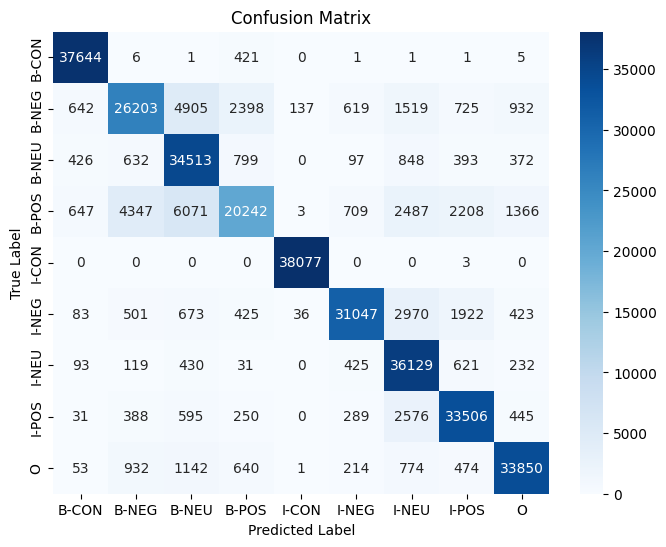

In [78]:
# Make predictions on the test set
y_train_rf_pred = rf_classifier.predict(X_train_rf_scaled)

# Evaluate the model
accuracy = accuracy_score(y_train_rf_resampled, y_train_rf_pred)
classification_rep = classification_report(y_train_rf_resampled, y_train_rf_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_train_rf_resampled, y_train_rf_pred, labels=rf_classifier.classes_)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The model performance looks very good on all metrics and all aspect tags. Can the model perform close to that on test data?

## 4.3. <a id='toc4_3_'></a>[Test](#toc0_)

Accuracy: 0.8342493491466589
Classification Report:
              precision    recall  f1-score   support

       B-CON       0.00      0.00      0.00         9
       B-NEG       0.15      0.23      0.18       215
       B-NEU       0.10      0.37      0.15       115
       B-POS       0.19      0.24      0.21       199
       I-CON       0.00      0.00      0.00         7
       I-NEG       0.22      0.21      0.21       105
       I-NEU       0.12      0.46      0.19        89
       I-POS       0.12      0.28      0.17        99
           O       0.97      0.88      0.93      9533

    accuracy                           0.83     10371
   macro avg       0.21      0.30      0.23     10371
weighted avg       0.90      0.83      0.87     10371



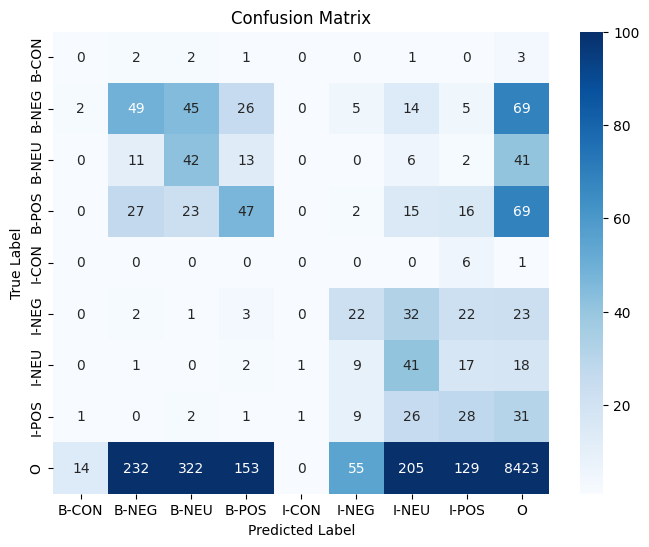

In [79]:
# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_rf_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_rf, y_pred_rf)
classification_rep = classification_report(y_test_rf, y_pred_rf)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_rf, y_pred_rf, labels=rf_classifier.classes_)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_, vmax=100, vmin=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Due to the nature of the very skewed dataset identified earlier, the model could not make any prediction on "I-CON" which is expected as the chances of having those tags in the results is also very rare. 

However, we can see that the model predict most words to be "O", and for those that it was able to predict not "O", it oftens confused between "B" & "I" and would almost predicting all results evenly between different sentiments.

In the end, the model performance has dropped significantly comparing to training set. The model was way overfitting, and it looks like the model could not learn much from the training data.

## 4.4. <a id='toc4_4_'></a>[Feature importance](#toc0_)

Text(0.5, 1.0, 'Top 10 important features')

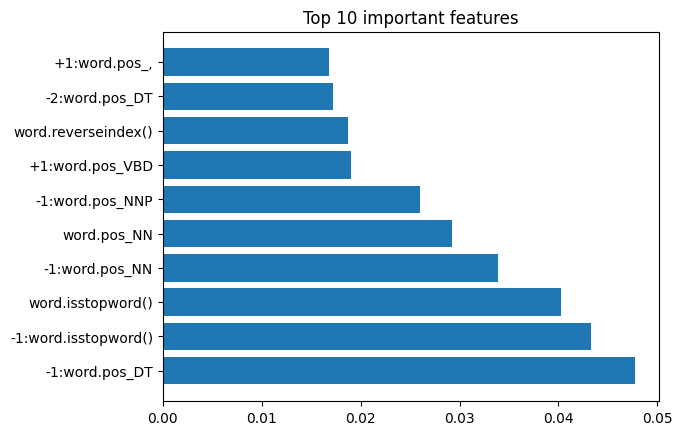

In [80]:
rf_feature_importance = pd.DataFrame({'feature': X_train_rf.columns, 'importance':rf_classifier.feature_importances_})
rf_feature_importance = rf_feature_importance.sort_values(by=['importance'], ascending=False)
plt.barh(rf_feature_importance['feature'][:10], rf_feature_importance['importance'][:10])
plt.title('Top 10 important features')

This shows that the random forest use information around whether the word is a noun or not for the prediction:
- \-1:word.pos_DT: whether word-1 is a determiner, e.g. the, a
- word.pos_NN: whether word is noun
- \+ 1:word.pos_VBD: next word is a verb, a.k.a word is a subject
...

This could explain why we see the model confused so much around the polarity.

# 5. <a id='toc5_'></a>[CRF model](#toc0_)

Conditional Random Field (CRF) model is a very famous algorithm for NER classification task. It is a type of discriminative undirected probabilistic graphical model.

Let's apply this model on our dataset and see how it will perform.

## 5.1. <a id='toc5_1_'></a>[Model](#toc0_)

In [81]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs',
                max_iterations=100,
                c1=0.5,
                c2=0.05)

# There is this error existing with this library: 'CRF' object has no attribute 'keep_tempfiles'
# which has not been resolved and we can bypass it using this trick.
try:
  crf_model.fit(X_train['features'], y_train)
except AttributeError:
  pass

Accuracy: 0.9937214891842842
Classification Report:
              precision    recall  f1-score   support

       B-CON       0.95      0.56      0.70        36
       B-NEG       0.97      0.87      0.92       651
       B-NEU       1.00      0.88      0.93       348
       B-POS       0.94      0.91      0.93       789
       I-CON       1.00      0.86      0.92        14
       I-NEG       0.99      0.96      0.97       352
       I-NEU       0.99      0.97      0.98       218
       I-POS       0.95      0.98      0.97       286
           O       1.00      1.00      1.00     38080

    accuracy                           0.99     40774
   macro avg       0.98      0.89      0.92     40774
weighted avg       0.99      0.99      0.99     40774



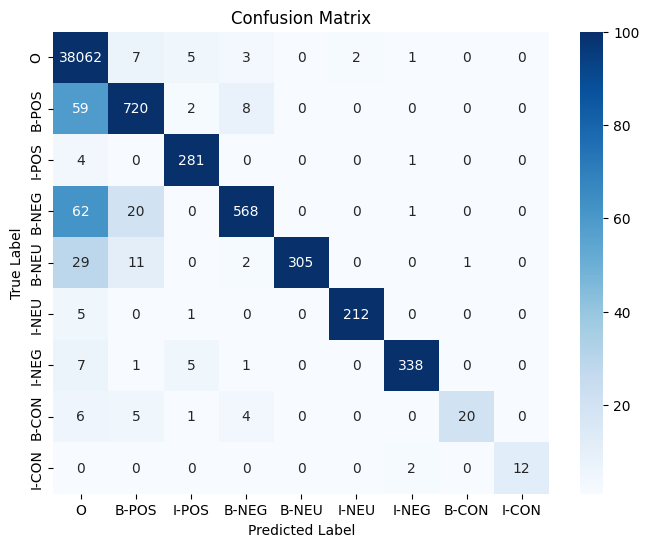

In [82]:
y_train_crf_pred = crf_model.predict(X_train['features'])

y_train_flat = [tag for sentence in y_train for tag in sentence]
y_train_crf_pred_flat = [tag for sentence in y_train_crf_pred for tag in sentence]


# Evaluate the model
accuracy = accuracy_score(y_train_flat, y_train_crf_pred_flat)
classification_rep = classification_report(y_train_flat, y_train_crf_pred_flat)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_train_flat, y_train_crf_pred_flat, labels=crf_model.classes_)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crf_model.classes_, yticklabels=crf_model.classes_, vmax=100, vmin=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


This CRF model also performs "super" well on our training data just like Random Forest. Are we going to see a significant drop in performance simiarly to Random Forest on test data as well?

## 5.2. <a id='toc5_2_'></a>[Test](#toc0_)

/Users/tina.vu/work/fun/sentilens_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tina.vu/work/fun/sentilens_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/tina.vu/work/fun/sentilens_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy: 0.9391572654517404
Classification Report:
              precision    recall  f1-score   support

       B-CON       0.00      0.00      0.00         9
       B-NEG       0.50      0.32      0.39       215
       B-NEU       0.36      0.22      0.27       115
       B-POS       0.56      0.48      0.52       199
       I-CON       0.00      0.00      0.00         7
       I-NEG       0.39      0.39      0.39       105
       I-NEU       0.52      0.36      0.42        89
       I-POS       0.46      0.31      0.37        99
           O       0.97      0.99      0.98      9533

    accuracy                           0.94     10371
   macro avg       0.42      0.34      0.37     10371
weighted avg       0.93      0.94      0.93     10371



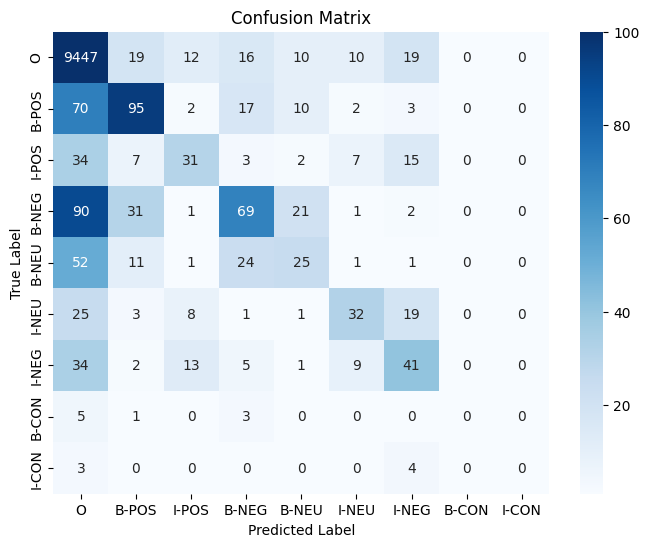

In [83]:
y_test_crf_pred = crf_model.predict(X_test['features'])

y_test_flat = [tag for sentence in y_test for tag in sentence]
y_test_crf_pred_flat = [tag for sentence in y_test_crf_pred for tag in sentence]


# Evaluate the model
accuracy = accuracy_score(y_test_flat, y_test_crf_pred_flat)
classification_rep = classification_report(y_test_flat, y_test_crf_pred_flat)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_test_crf_pred_flat, labels=crf_model.classes_)

# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crf_model.classes_, yticklabels=crf_model.classes_, vmax=100, vmin=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Similarly to Random Forest mode, CRF performance has also dropped a lot. It also tend to classify most records to "O" class, while there was no words predicted as "conflict". "B" & "I" seem to be pre

The model also could not distinguish the aspect sentiments very well. However, we can see that fewer "I" words are being predicted as "B" and vice versa.

So in general, CRF does have a slightly better improvement comparing to Random Forest and that "conflict" aspects are almost impossible to be predicted given how scarce the label is. We may want to incorporate "conflict" into "negative" as they seems to match their profile better, and will make it easier for the model to perform.

## 5.3. <a id='toc5_3_'></a>[Further look into the model's mistakes](#toc0_)

In [84]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Label transition proability score:")
print_transitions(Counter(crf_model.transition_features_).most_common())


Label transition proability score:
B-NEG  -> I-NEG   6.935725
B-POS  -> I-POS   6.599966
I-POS  -> I-POS   6.333174
B-NEU  -> I-NEU   6.235767
B-CON  -> I-CON   6.065738
I-NEG  -> I-NEG   5.992701
I-NEU  -> I-NEU   5.284141
I-CON  -> I-CON   2.609678
O      -> B-POS   2.561054
O      -> O       2.489118
O      -> B-NEG   1.718510
O      -> B-NEU   1.500756
O      -> B-CON   0.926945
B-NEG  -> O       0.212987
B-POS  -> O       -0.001109
I-NEG  -> O       -0.180419
I-NEU  -> O       -0.219391
I-POS  -> O       -0.262960
B-NEU  -> O       -0.334603
B-CON  -> O       -1.007125
I-CON  -> O       -1.506421


- We can see that it is very unlikely that once a model predicted a word as an aspect term to be non-aspect term. However, there are some decent chances that non-aspect term can be predicted as aspect terms. We can also look into some other types of model like Uhmm which will return a probability for each class prediction and may make some adjustment to remove lower proprability prediction of class "O" and pick the next highest probabable class prediction in the post-processing steps.

- Additionally, we can also see that there are high chances that the "B" words can be predicted as "I" as well. Per construction, every "I" word chain has to have a preceding "B", therefore, if there was no "B" that "I" chunk can be invalid. On the otherhand, we may also need to look into whether our chunks have been broken down too much, as whether we are ppredicting more singular aspect terms than multi-word aspect terms. This can also be re-adjusted based on our post-processing steps to ensure the construction rule is followed.

## 5.4. <a id='toc5_4_'></a>[BIO construction violations](#toc0_)

Just a quick look to see if there is any BIO construction violations in our predictions:
- BI: every "I" word chain has to have a preceding "B", therefore, if there was no "B" that "I" chunk can be invalid.
- BB: it is very unlikely that two consecutive aspect terms do not have any seperator (another token in between).

In [85]:
def check_BIO_construction_violations (tags):
  # Convert to BIO tag - removing sentiment
  bio_y = [[word[:1] for word in sentence]for sentence in tags]
  # Join all tags in sentence to make a string of BIO tags
  bio_str = [''.join(sentence) for sentence in bio_y]

  # Test if all "I" chunks have preceeding "B"
  # Find in string if there is any "I" in the first word or "I" with "O" preceding
  bi_violations = [i  for i,sentence in enumerate(bio_str) if (re.match('^I.*',sentence) or re.match('.*OI.*',sentence))] # return sentence index if any violations found
  print('BI violations in data: ', len(bi_violations))

  # Test if there are any "BB", a.k.a consecutive aspect terms. This can happen in reality, but also is very rare, as they are normally separated by some kind punctuations
  # if there is any violations we can look into it 
  bb_violations = [i for i, sentence in enumerate(bio_str) if (re.match('.*BB.*',sentence))]
  print('BB violations in data: ', len(bb_violations))

  return bi_violations, bb_violations, bio_str


In [86]:
print('Check for BIO construction violations in predicted training data prediction')
train_pred_bi_violations, train_pred_bb_violations, train_pred_bio_string = check_BIO_construction_violations(y_train_crf_pred)

print('\nCheck for BIO construction violations in predicted test data prediction')
test_pred_bi_violations, test_pred_bb_violations, test_pred_bio_string = check_BIO_construction_violations(y_test_crf_pred)

print('\nCheck for BIO construction violations in training data prediction')
train_bi_violations, train_bb_violations, train_bio_string = check_BIO_construction_violations(y_train.array)

print('\nCheck for BIO construction violations in test data prediction')
test_bi_violations, test_bb_violations, test_bio_string = check_BIO_construction_violations(y_test.array)

Check for BIO construction violations in predicted training data prediction
BI violations in data:  0
BB violations in data:  1

Check for BIO construction violations in predicted test data prediction
BI violations in data:  0
BB violations in data:  0

Check for BIO construction violations in training data prediction
BI violations in data:  0
BB violations in data:  1

Check for BIO construction violations in test data prediction
BI violations in data:  0
BB violations in data:  0


It is intersting that we do not have "BI" violations. But there is one in the training dataset as well as 1 in our training prediction as well. 

Let's have a look at these sentences.

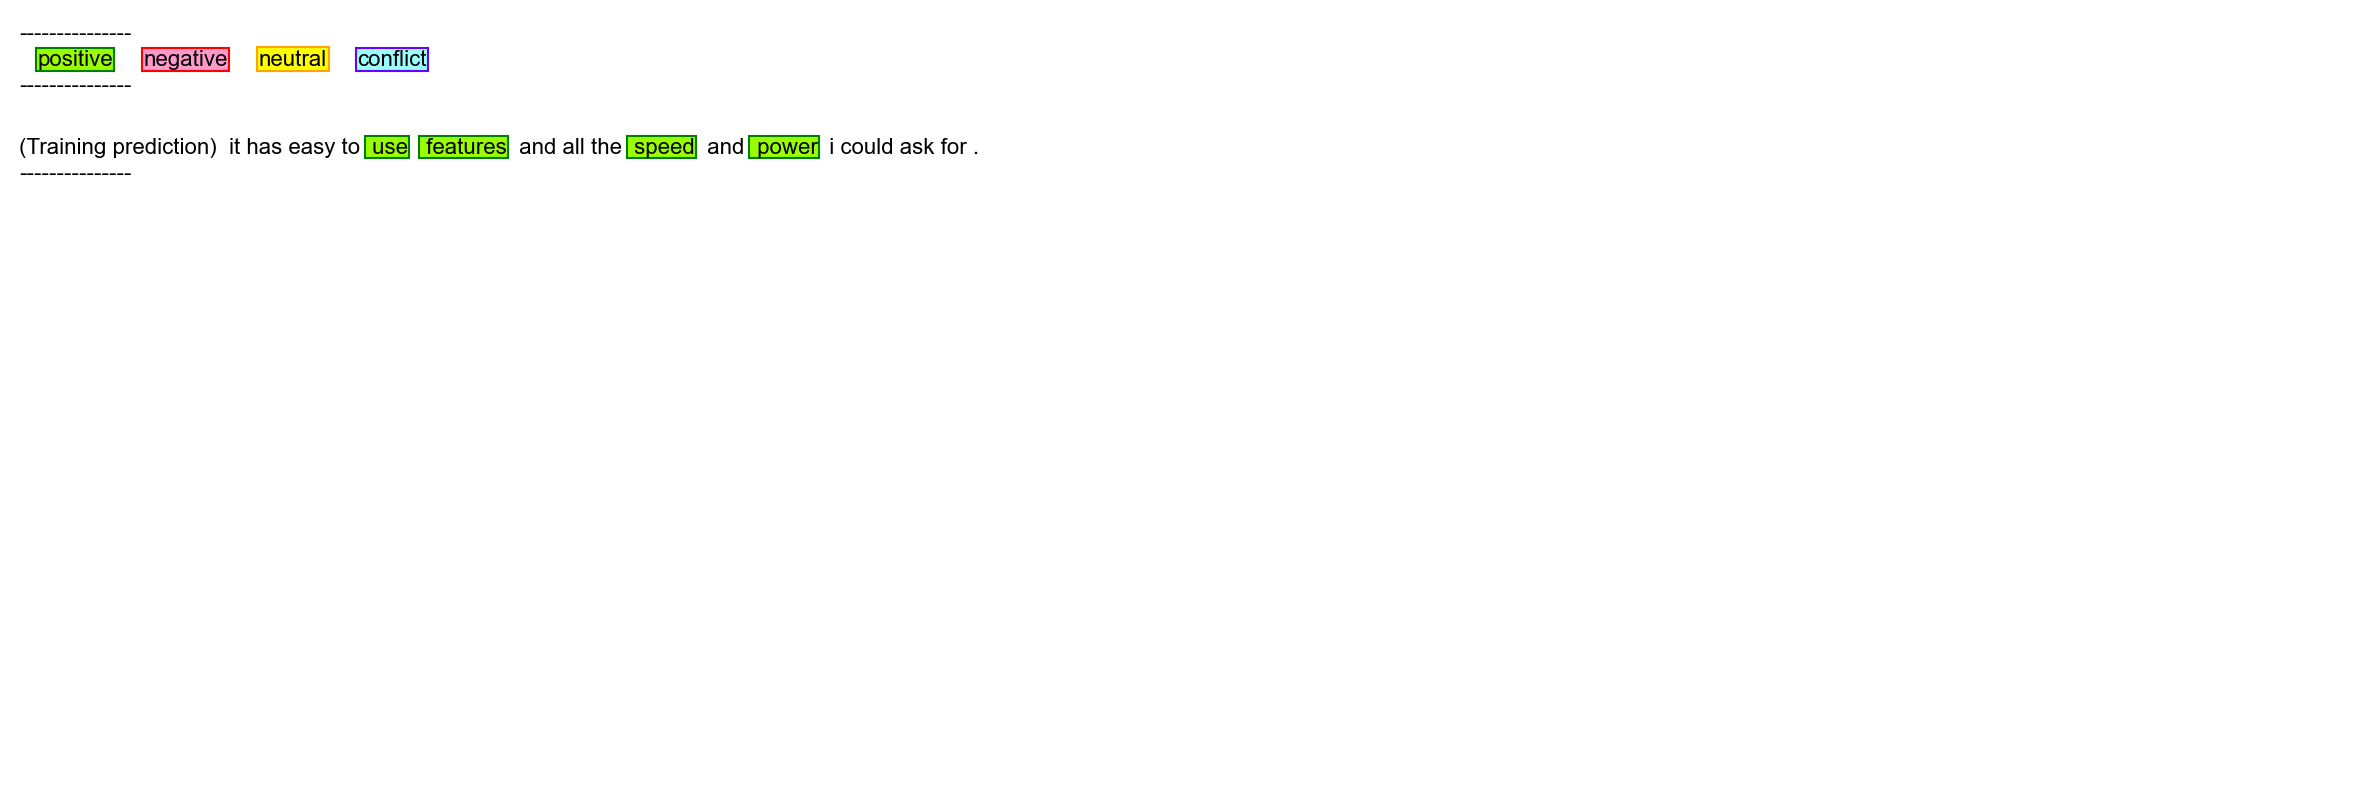

In [87]:
tags = [y_train_crf_pred[train_pred_bb_violations[0]]]
sentences = [[x['word.lower()'] for x in X_train.iloc[train_pred_bb_violations[0]]['features']]]
vizualize_samples(sentences, {'Training prediction': tags})


This is prediction value so we expect this to happen.

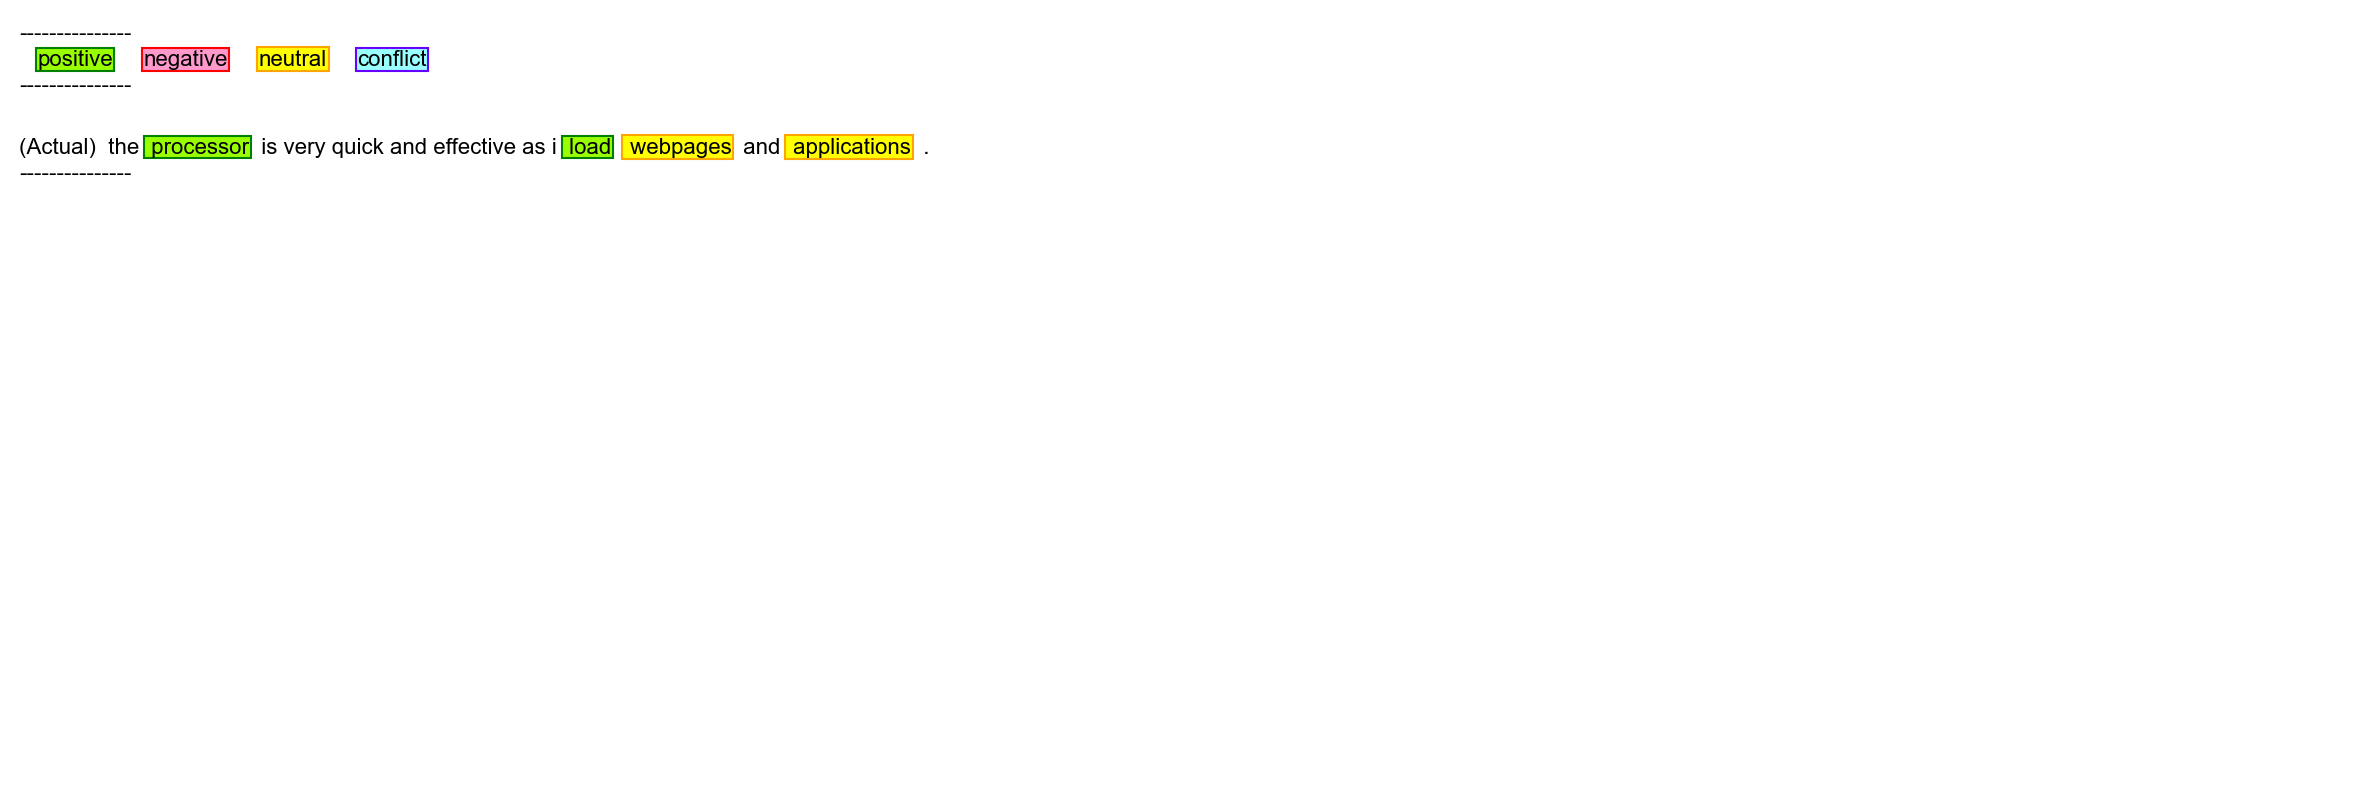

In [88]:
tags = [y_train.iloc[train_bb_violations[0]]]
sentences = [[x['word.lower()'] for x in X_train.iloc[train_bb_violations[0]]['features']]]
vizualize_samples(sentences, {'Actual': tags})


# 6. <a id='toc6_'></a>[Model evaluation](#toc0_)

## 6.1. <a id='toc6_1_'></a>[Metric for model evaluation](#toc0_)

Since NER is a multi-class classification task, we cannot look into each individual tag's metrics to evaluate different models. We need a single metric that can unified other individual tag's performance.

Here I would use __macro average f1-score__ for our model evaluation and selection:
- f1-score is a harmonic metric that gives us a balance view on our imbalanced dataset
- Also a macro average is selected in order to combine all idividual tag metrics together. I selected "macro" instead of "micro" average as it gives more balanced evaluation regardless of the imbalanced distribution of the tags in the dataset & the likelyhood of correctly predicting the dominant class.

In [93]:
from sklearn.metrics import f1_score

print('Macro avg f1-score:')
print('Random Forest: ', f1_score(y_test_rf, y_pred_rf, average='macro'))
print('CRF          : ', f1_score(y_test_flat, y_test_crf_pred_flat, average='macro'))

Macro avg f1-score:
Random Forest:  0.22742393733290278
CRF          :  0.37158571427681064


From this metric, we can see that a default CRF model has already improved the performance by > 1.5x times comparing to Random Forest. 

If we were to provided better word embeddings (features) to the model, and tuning the context windows, and other hyper-parameters, I believe the model performance will improve significantly.

# 7. <a id='toc7_'></a>[Sample visualization](#toc0_)

Let's have a look at a few examples to see how our CRF model did.

177


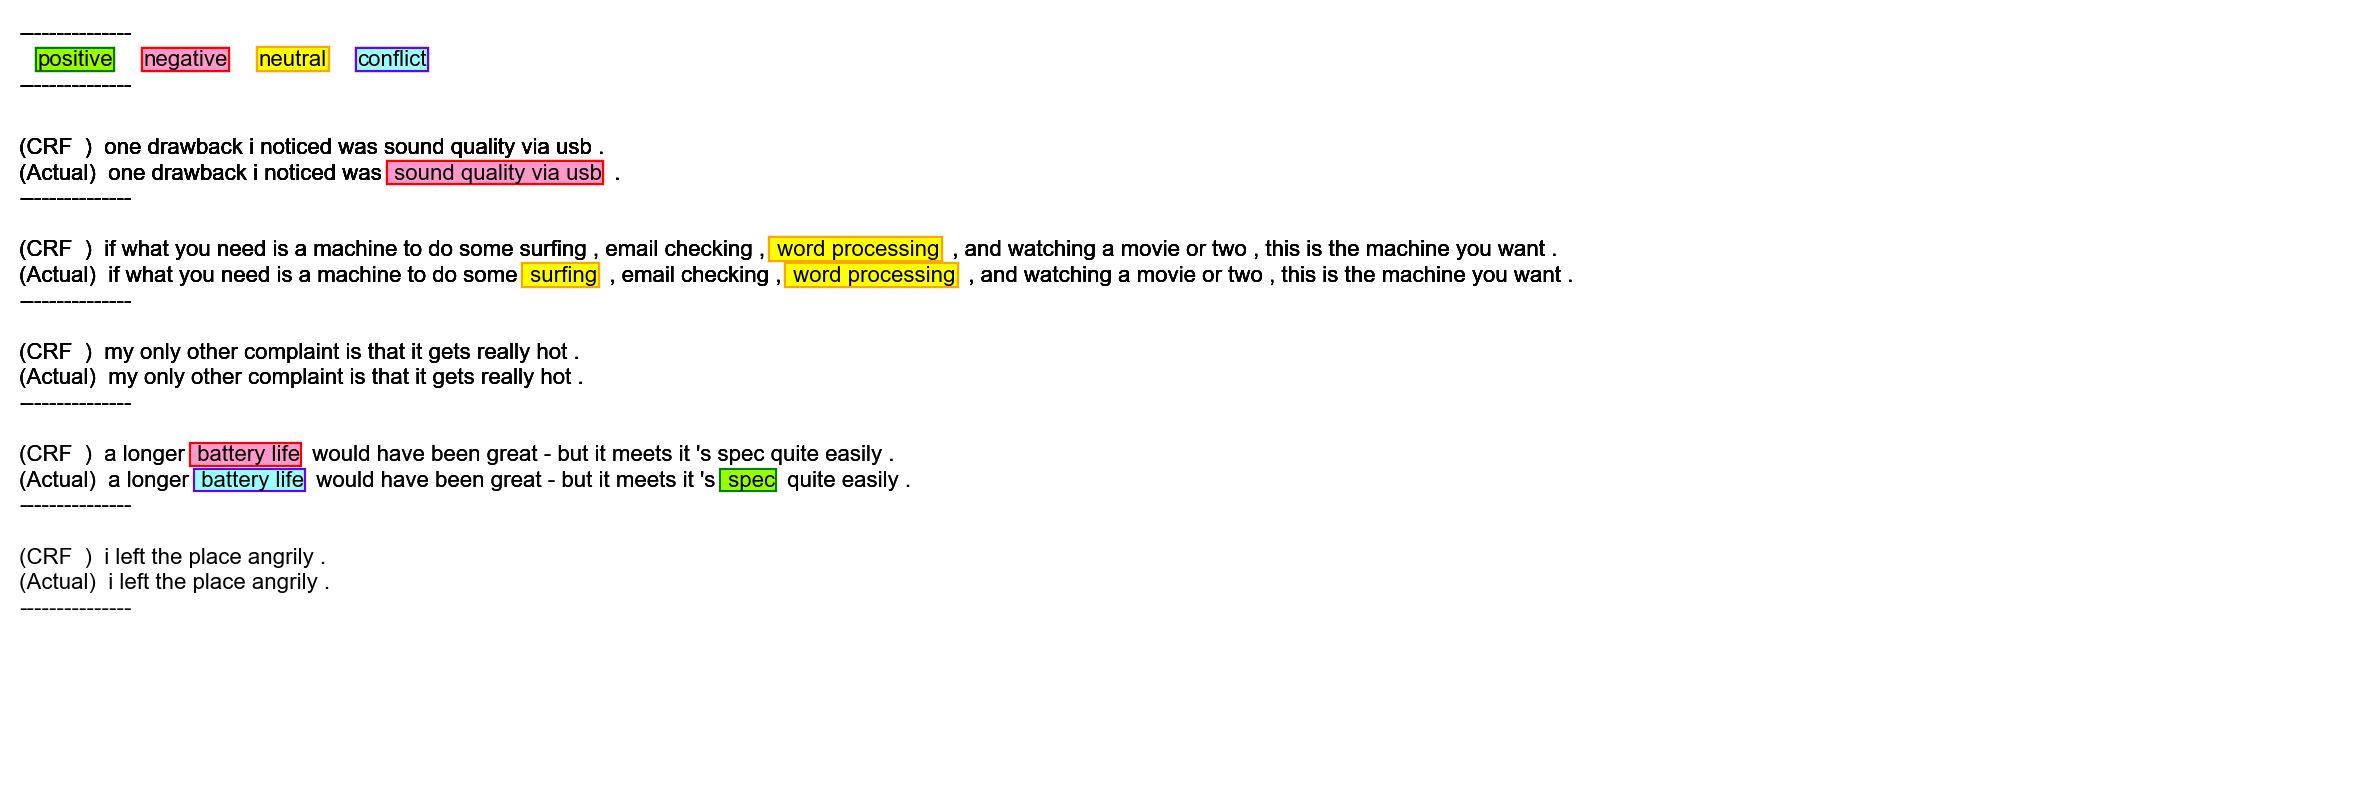

In [94]:
samples = 5
integer = 177
# integer = random.randint(0,len(X_test) - samples) # Enable this & disable prev line, to generate random samples
tags = y_test[integer:integer+samples].array
pred_tags = crf_model.predict(X_test['features'][integer:integer+samples])
sentences = [[x['word.lower()'] for x in sentence] for sentence in X_test['features'][integer:integer+samples]]

print(integer)
vizualize_samples(sentences, {'CRF  ':pred_tags, 'Actual': tags})


The results do not look so bad. 

On the first sentence, the model seems to not being able to extract any aspect. 
The fourth sentence, "battery life" was predicted as "negative" instead of "conflict". Given the scarcity of "conflict", I may want to classify "conflict" as "negative" in the next iteration. For "neutral" aspects, I may also consider removing them all together, as we want to provide opinionated aspects, otherwise it is not as valuable to our end users. But these will be covered in the next model iterations.

# 8. <a id='toc8_'></a>[Next steps](#toc0_)
__Feature improvement__</br>
Add more features:  head words,  Google Word2Vec word embeddings

__Unsupervised training__</br>
Re-train model using rule-based aspect term extraction on larger dataset

__Productionize__</br>
An app to allow users to look for specific product reviews & filter review by aspects + summarize aspect sentiments
